<a href="https://colab.research.google.com/github/anqi-guo/duplicated_complaints_identification/blob/main/4_sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

path = '/content/drive/My Drive/work/重复线索识别/data/labeled_data'

df = pd.read_excel(f'{path}/final_data.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
df['label'].value_counts()

0.0    10563
1.0     2042
Name: label, dtype: int64

In [ ]:
# downsample non-duplicated data
df_dup = df[df['label']==1]

df_nondup = df[df['label']==0]
df_nondup_downsampled = df_nondup.sample(df_dup.shape[0])

df_balanced = pd.concat([df_dup, df_nondup_downsampled])

df_balanced['label'].value_counts()

1.0    1765
0.0    1765
Name: label, dtype: int64

In [35]:
# split data into train, val, and test
train_list = []
val_list = []
test_list = []
for i in range(2):
  data = df[df['label']==i]

  train_data = data.sample(frac=.9, random_state=0)
  train_list.append(train_data)

  temp_data = pd.concat([data, train_data]).drop_duplicates(keep=False)
  val_data = temp_data.sample(frac=.5, random_state=0)
  val_list.append(val_data)

  test_data = pd.concat([temp_data, val_data]).drop_duplicates(keep=False)
  test_list.append(test_data)

train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)

train_df.shape, val_df.shape, test_df.shape

((11345, 3), (628, 3), (629, 3))

In [15]:
! pip install -U sentence-transformers

In [41]:
from sentence_transformers import models, SentenceTransformer, util
import torch.nn as nn

#MODEL_NAME = 'imxly/sentence_rtb3'
#MODEL_NAME = 'uer/sbert-base-chinese-nli'
MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
MAX_SEQ_LENGTH = 128
OUT_FEATURES_DIM = 256

word_embedding_model = models.Transformer(MODEL_NAME, max_seq_length=MAX_SEQ_LENGTH)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode_mean_tokens=True, pooling_mode_cls_token=False, pooling_mode_max_tokens=False)
#dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=OUT_FEATURES_DIM, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[
                                     word_embedding_model, 
                                     pooling_model, 
                                     #dense_model
                                     ])

# test set prediction before fine-tuning

  0%|          | 0/629 [00:00<?, ?it/s]

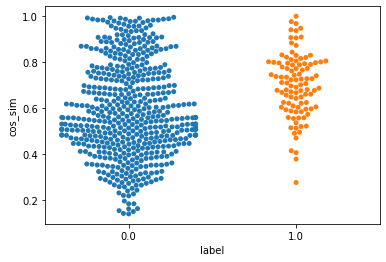

In [44]:
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

test_df['cos_sim'] = test_df.progress_apply(lambda row: util.pytorch_cos_sim(model.encode(row['sentence1']), model.encode(row['sentence2'])).item(), axis=1)
test_df['label'] = test_df['label'].astype(str)
sns.swarmplot(data=test_df, y='cos_sim', x='label')

# fine-tune model

In [45]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, evaluation, losses, models, util
from torch.utils.data import DataLoader
import torch.nn as nn

#model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# define train examples
train_data = []
for idx, row in train_df.iterrows():
  train_data.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=row['label']))

# define evaluation examples
sentences1 = val_df['sentence1'].tolist()
sentences2 = val_df['sentence2'].tolist()
labels = val_df['label'].tolist()
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, labels)

# define train dataset, the dataloader and the train loss
train_dataset = SentencesDataset(train_data, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(model=model)


model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=10, 
          warmup_steps=100, 
          evaluator=evaluator, 
          evaluation_steps=10, 
          output_path='/content/drive/My Drive/work/重复线索识别/models/sb')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/355 [00:00<?, ?it/s]

# test set prediction after fine-tuning

  0%|          | 0/629 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


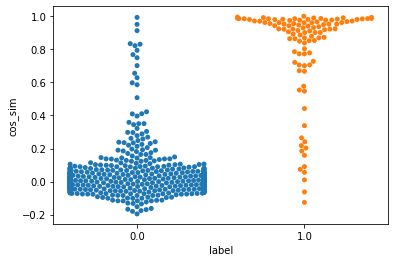

In [46]:
test_df['cos_sim'] = test_df.progress_apply(lambda row: util.cos_sim(model.encode(row['sentence1']), model.encode(row['sentence2'])).item(), axis=1)
test_df['label'] = test_df['label'].astype(str)
sns.swarmplot(data=test_df, y='cos_sim', x='label')

In [47]:
test_df.query('label=="1.0" and cos_sim<.5')

,label,sentence1,sentence2,cos_sim
2298,1.0,梁岔镇中心小学唯一门口有人搭建棚子做学生保险代办点每天高音喇叭叫卖来电希望禁止噪音扰民,涟水县梁岔镇中心小学门口每个月逢集时早上点有人叫卖来电希望部门制止禁止噪音扰民,0.338257
4498,1.0,王家营街道幸福城期B区门口多家烧烤店油烟扰民严重清洗污水随意路边散发臭味,淮阴区幸福城小区门侧新疆喀什烤肉王锅武侠硬啃酱骨火锅每天营业时油烟扰民严重影响居民生活来电希...,0.240783
4508,1.0,王家营街道幸福城期B区门口多家烧烤店油烟扰民严重清洗污水随意路边散发臭味,淮阴区幸福城期号楼草原羊肉馆油烟直接区内排放油烟扰民严重希望督促商家进行整改解决油烟扰民问题,0.202937
5791,1.0,樱桃园路樱桃园路梁红玉路交口路侧樱桃园路阿刚鱼头正私自开设油烟出口未安装净化装置地图有误,樱桃园路樱桃园路梁红玉路交口路侧樱桃园路子砚斋书法正道路厚油渍,-0.062716
6001,1.0,一品村小区住户来电反映位于清河路上海路交叉口处一品村小区号楼下密房小馆扇贝王油烟扰民影响周边...,清江浦区清河路一品村扇贝王每天营业时油烟严重影响居民生活来电希望部门尽快解决油烟扰民问题,0.264657
6828,1.0,健康路康城明珠门面淮扬菜馆每天经营期间未经处理油烟空气中直接排放油烟扰民严重来电希望协调督促...,第二十九批第件受理编号D淮安市清江浦区健康路号中国银行宿舍楼室开饭店油烟扰民,-0.125750
7124,1.0,月云梦清河工地夜间混凝土搅拌现场车辆鸣笛噪音扰民催办清江浦区环保告知审批市民表示施工噪音超出...,云梦清河一期神旺臻缘苑每天夜间施工噪音扰民来电希望相关部门协调解决夜间施工噪音扰民问题,0.055933
7197,1.0,柯山路乾隆御景华德力运河城侧工地施工噪音扰民来电希望相关部门加强管理禁止噪音扰民,华德力运河城小区侧近期规划道路晚间施工方使用挖掘机进行平整道路施工声响较大噪音扰民道路施工应...,0.184781
8047,1.0,上海花园淮城面馆油烟飘落面馆烟囱固定号楼单元门楼梯道外墙上直通顶楼单元门对面小区内部停车位每...,上海花园小区内部青年路青年路金鼎路交口路侧上海花园小区内部上海花园幢二单元油烟污染,0.158924
8147,1.0,承德路健康路交叉口七七烧烤餐饮油烟直排,健康路号新开烧烤店无名下水道窨井盖拿掉油烟管道塞敞开口市民表示油烟污染来电希望恢复窨井盖禁止...,0.074071
